# What is PyTorch?
* Its a machine learning library used for NLP, computer vision,etc.
* Provides Tensor computing with GPU support.

# Modules in Pytorch
*  **Autograd module:**
PyTorch uses a method called automatic differentiation. A recorder records what operations have performed, and then it replays it backward to compute the gradients. This method is especially powerful when building neural networks to save time on one epoch by calculating differentiation of the parameters at the forward pass.

* **Optim module:**
torch.optim is a module that implements various optimization algorithms used for building neural networks. 

* **nn module:**
PyTorch autograd makes it easy to define computational graphs and take gradients, but raw autograd can be a bit too low-level for defining complex neural networks. This is where the nn module can help.

# Topics covered in this notebook
* Handwritten Digits Classification (Numerical Data)-**Digit MNIST**
* Objects Image Classification (Image Data, CNN)-**Sign Language MNIST**


# Handwritten Digits Classification (Numerical Data)-Digit MNIST

### Importing lib

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline
import time

#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

start = torch.cuda.Event(enable_timing=True) #time measure during cuda training
end = torch.cuda.Event(enable_timing=True)

### Importing dataset 

In [2]:
test_df = pd.read_csv('../input/mnist-in-csv/mnist_test.csv')
train_df = pd.read_csv('../input/mnist-in-csv/mnist_train.csv')
train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Separating labels and features (pixel)

In [3]:
train_labels = train_df['label'].values # converting to numpy also

test_labels=test_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,1:].values).astype('float32')

In [4]:
print("train images shape",train_images.shape)
print("train labels shape",train_labels.shape)
print("test images shape",test_images.shape)
print("test labels shape",test_labels.shape)

train images shape (60000, 784)
train labels shape (60000,)
test images shape (10000, 784)
test labels shape (10000,)


### Reshape features

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


### Visualize some training images

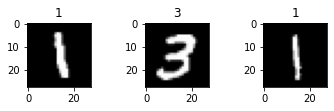

In [6]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])


### Convert numpy data into tensor for PyTorch
* torch.tensor default uses float
* feature are divided by 255 to change them into suitable range

In [7]:
train_images_tensor = torch.tensor(train_images)/255.0 #default torch.FloatTensor
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

test_images_tensor = torch.tensor(test_images)/255.0
test_labels_tensor = torch.tensor(test_labels)
test_tensor = TensorDataset(test_images_tensor, test_labels_tensor)

### DataLoader for train and test 
* Batch size 16

In [8]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

### Model

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h)
        return out

model = Model()

### Checking for cuda availability

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if (device.type=='cuda'):
    model.cuda() # convert model to cuda model

    
optimizer = optim.Adam(model.parameters(), lr=0.001) #adam optimizer from optim module

cuda


In [11]:
if (device.type=='cuda'):
    start.record() #timer start

model.train()


losses = []
for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        if (device.type=='cuda'):
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target) # making group of 16
            
        
        # Init
        optimizer.zero_grad() #making gradient zero for new mini-batch. 

        # Predict
        y_pred = model(data) 
         
        
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()  #It computes gradient of loss w.r.t all the parameters and store them in (parameter.grad) attribute.
        optimizer.step() #optimizer.step() updates all the parameters based on (parameter.grad)
        
        
        # Display
        #if batch_idx % 100 == 1:
        print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data), end='')
            
    print()
    
if (device.type=='cuda'):
    end.record()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Train Epoch: 0 [59984/60000 (100%)]	Loss: 0.078582
 Train Epoch: 1 [59984/60000 (100%)]	Loss: 0.329871
 Train Epoch: 2 [59984/60000 (100%)]	Loss: 0.155539
 Train Epoch: 3 [59984/60000 (100%)]	Loss: 0.013120
 Train Epoch: 4 [59984/60000 (100%)]	Loss: 0.226431
 Train Epoch: 5 [59984/60000 (100%)]	Loss: 0.153548
 Train Epoch: 6 [59984/60000 (100%)]	Loss: 0.013032
 Train Epoch: 7 [59984/60000 (100%)]	Loss: 0.005125
 Train Epoch: 8 [59984/60000 (100%)]	Loss: 0.035286
 Train Epoch: 9 [59984/60000 (100%)]	Loss: 0.111835
 Train Epoch: 10 [59984/60000 (100%)]	Loss: 0.324415
 Train Epoch: 11 [59984/60000 (100%)]	Loss: 0.124107
 Train Epoch: 12 [59984/60000 (100%)]	Loss: 0.158513
 Train Epoch: 13 [59984/60000 (100%)]	Loss: 0.042156
 Train Epoch: 14 [59984/60000 (100%)]	Loss: 0.023657
 Train Epoch: 15 [59984/60000 (100%)]	Loss: 0.019556
 Train Epoch: 16 [59984/60000 (100%)]	Loss: 0.027390
 Train Epoch: 17 [59984/60000 (100%)]	Loss: 0.140433
 Train Epoch: 18 [59984/60000 (100%)]	Loss: 0.006098
 Tr

### Predicting the output and accuracy

In [12]:
if (device.type=='cuda'):
    evaluate_x=test_images_tensor.cuda()
    evaluate_y=test_labels_tensor.cuda()
else:
    evaluate_x=test_images_tensor
    evaluate_y=test_labels_tensor
    

output = model(evaluate_x)

pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
a=(d.sum().data.cpu().numpy())
b=d.size()
b=torch.tensor(b)
b=(b.sum().data.cpu().numpy())
accuracy = a/b

print('Accuracy:', accuracy)

Accuracy: 0.9758


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 ### Time used for training if cuda is used

In [13]:
if (device.type=='cuda'):
    torch.cuda.synchronize()
    print(start.elapsed_time(end)/1000,"sec")

415.8584375 sec


# Objects Image Classification (Image Data, CNN)-Sign Language MNIST

### Loading dataset

In [14]:
test_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
train_df = pd.read_csv('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')

In [15]:
print((train_df['label'].unique()).shape )# There are 24 possible labels, 9=J and 25=Z require motion so they are absent.
print(np.sort(train_df['label'].unique()))

(24,)
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


### Separating labels and features

In [16]:
train_labels = train_df['label'].values
test_labels=test_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,1:].values).astype('float32')

In [17]:
print("train images shape",train_images.shape)
print("train labels shape",train_labels.shape)
print("test images shape",test_images.shape)
print("test labels shape",test_labels.shape)

train images shape (27455, 784)
train labels shape (27455,)
test images shape (7172, 784)
test labels shape (7172,)


### Reshape features
*Note: For images reshape will be in 4D*

In [18]:
train_images = train_images.reshape(train_images.shape[0],1, 28, 28)
test_images = test_images.reshape(test_images.shape[0],1, 28, 28)

In [19]:
print(train_images.shape)
print(test_images.shape)

(27455, 1, 28, 28)
(7172, 1, 28, 28)


### Changing to Tensor

In [20]:
train_images_tensor = torch.tensor(train_images)/255.0 #default torch.FloatTensor
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

test_images_tensor = torch.tensor(test_images)/255.0
test_labels_tensor = torch.tensor(test_labels)
test_tensor = TensorDataset(test_images_tensor, test_labels_tensor)

### DataLoader

In [21]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

### Model

In [22]:
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

class Net(nn.Module):                                           # class Net inherits from predefined Module class in torch.nn
    def __init__(self):                                         # calling constructor of  parent class
        super().__init__()                                     
        
        
        self.conv1 = nn.Conv2d(1,32,3)              # 2d convolution layer : (input : 1 image , output : 32 channels , kernel size : 3*3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        
        self.linear_in = None                      # used to calculate input of first linear layer by passing fake data through 2d layers
        x = torch.rand(28,28).view(-1,1,28,28)     # using convs function
        self.convs(x)
    
        self.fc1 = nn.Linear(self.linear_in,512)
        self.fc2 = nn.Linear(512,26)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)) , (2,2) )      # relu used for activation function 
        x = F.max_pool2d(F.relu(self.conv2(x)) , (2,2) )      # max_pool2d for max pooling results of each kernel with window size 2*2
        x = F.max_pool2d(F.relu(self.conv3(x)) , (2,2) )
        
        if self.linear_in == None:
            self.linear_in = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]  # input of first linear layer is multiplication of dimensions of ouput 
        return x                                                        # tensor of the 2d layers
    
    def forward(self,x):                                    # forward pass function uses the convs function to pass through 2d layers
        x = self.convs(x)
        x = x.view(-1,self.linear_in)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x ,dim = -1)                     # log_softmax for finding output neuron with highest value
        return x
    
net = Net()

In [23]:
print(net)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if (device.type=='cuda'):
    model.cuda() # CUDA

net.to(device)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=26, bias=True)
)
cuda


In [24]:
if (device.type=='cuda'):
    start.record() 
    
loss_log = []
for epoch in range(20): # loop over dataset multiple times
    running_loss = 0.0
    for i, (data,target) in enumerate(train_loader):

        
        if (device.type=='cuda'):
            inputs,labels= Variable(data.cuda()), Variable(target.cuda())
        else:
            inputs,labels= Variable(data), Variable(target)
       
        
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)

        loss =  F.cross_entropy(outputs, labels)
        #print(loss)
        
   
        
        loss.backward()
        optimizer.step()
        
      
        #if i % 100 == 1:
        print('\r Train Epoch: {} [{}/{} ({:.0f}%)] \tLoss: {:.6f}'.format( epoch, i * len(data), len(train_loader.dataset),
                                                                           100. * i / len(train_loader), loss.data), end='')
        
    print("")
                
print('Finished Training')
if (device.type=='cuda'):
    end.record()

 Train Epoch: 0 [25725/27455 (100%)] 	Loss: 0.208132
 Train Epoch: 1 [25725/27455 (100%)] 	Loss: 0.005389
 Train Epoch: 2 [25725/27455 (100%)] 	Loss: 0.022597
 Train Epoch: 3 [25725/27455 (100%)] 	Loss: 0.000477
 Train Epoch: 4 [25725/27455 (100%)] 	Loss: 0.000133
 Train Epoch: 5 [25725/27455 (100%)] 	Loss: 0.000060
 Train Epoch: 6 [25725/27455 (100%)] 	Loss: 0.004529
 Train Epoch: 7 [25725/27455 (100%)] 	Loss: 0.002645
 Train Epoch: 8 [25725/27455 (100%)] 	Loss: 0.000051
 Train Epoch: 9 [25725/27455 (100%)] 	Loss: 0.000004
 Train Epoch: 10 [25725/27455 (100%)] 	Loss: 0.000001
 Train Epoch: 11 [25725/27455 (100%)] 	Loss: 0.005079
 Train Epoch: 12 [25725/27455 (100%)] 	Loss: 0.000011
 Train Epoch: 13 [25725/27455 (100%)] 	Loss: 0.000001
 Train Epoch: 14 [25725/27455 (100%)] 	Loss: 0.000003
 Train Epoch: 15 [25725/27455 (100%)] 	Loss: 0.000009
 Train Epoch: 16 [25725/27455 (100%)] 	Loss: 0.000000
 Train Epoch: 17 [25725/27455 (100%)] 	Loss: 0.000197
 Train Epoch: 18 [25725/27455 (100%)] 

In [25]:
if (device.type=='cuda'):
    evaluate_x=test_images_tensor.cuda()
    evaluate_y=test_labels_tensor.cuda()
else:
    evaluate_x=test_images_tensor
    evaluate_y=test_labels_tensor
    

output = net(evaluate_x)

pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
a=(d.sum().data.cpu().numpy())
b=d.size()
b=torch.tensor(b)
b=(b.sum().data.cpu().numpy())
accuracy = a/b

print('Accuracy:', accuracy*100)

Accuracy: 93.25153374233128


In [26]:
if (device.type=='cuda'):
    torch.cuda.synchronize()
    print(start.elapsed_time(end)/1000,"sec")

200.3401875 sec


### Calculating the F1 score

In [27]:
from sklearn.metrics import f1_score
print("f1 score =",f1_score(test_labels, pred.cpu().numpy(), average='macro'))

f1 score = 0.9268968946741317


# Other use case to be covered in upcoming notebook

* R-CNN
* Sentiment Text Classification (Text Data, RNN)
* Image Style Transfer (Transfer Learning)

## Conclusion
Lets get connected on [Linkedin](https://www.linkedin.com/in/manzoor-bin-mahmood/)

Visit my [website](https://manzoormahmood.github.io/) 

### Please **upvote** my work if you like it.